# Analyzing the Mercari children's book dataset

## Import libraries and files

In [13]:
%matplotlib notebook
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split

os.chdir('/Users/mleong/github/used-books')
books = pd.read_csv('used-book-data.csv')
books.head()


,brand,category,condition,description,id,posted,price,seller_name,shipping,sold,title
0,NaN,"Other,Books,Children's books",New,Free with another book purchase,84914972647,07/10/17,$3,C Sells,$4.00 | from Texas,Buy now,Book
1,NaN,"Other,Books,Children's books",New,Book-When Bad Thinds Happen in God's Wonderful...,28411714700,07/15/17,$3,Investinyou,$4.00 | 3+ days | from Texas,Buy now,Book- When Bad Things Happen
2,NaN,"Other,Books,Children's books",New,This listing is for one book. Please let me kn...,21933816748,05/26/19,$11,HWalters55,Free | from Washington,Buy now,Usborne Wipe-Clean- NEW
3,NaN,"Other,Books,Children's books",New,Brand new. Never used. Ask me about bundling.,89750511304,11/11/17,$3,Bargain hauls,$4.00 | 3+ days | from Minnesota,Buy now,Jingle Bells Book
4,NaN,"Other,Books,Children's books",New,My Sister The Vampire Vampalicious. New softco...,496308655,08/19/16,$4,Dustyattic,Free | from Connecticut,Buy now,My Sister The Vampire


In [14]:
# Row count
rows = books.shape[0]
print("Number of rows: ", str(rows))

# Column count
columns = books.shape[1]
print("Number of columns: ", str(columns))

# Column names
print("Column names: ", str(books.columns))

# Indexing method
print("Index method: ", str(books.index))

# Data types of all columns
print("Data types for entire dataframe: ")
books.info()

# Data type of particular column
print("Data type of price column specifically is: ", str(books.price.dtype))



Number of rows:  49481
Number of columns:  11
Column names:  Index(['brand', 'category', 'condition', 'description', 'id', 'posted',
       'price', 'seller_name', 'shipping', 'sold', 'title'],
      dtype='object')
Index method:  RangeIndex(start=0, stop=49481, step=1)
Data types for entire dataframe: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49481 entries, 0 to 49480
Data columns (total 11 columns):
brand          25163 non-null object
category       49478 non-null object
condition      49481 non-null object
description    49481 non-null object
id             49481 non-null int64
posted         49481 non-null object
price          49481 non-null object
seller_name    49481 non-null object
shipping       49481 non-null object
sold           49481 non-null object
title          49481 non-null object
dtypes: int64(1), object(10)
memory usage: 4.2+ MB
Data type of price column specifically is:  object


## Clean-up time!

### Fix existing features

In [15]:
# eliminate duplicate rows
books = books.drop_duplicates()

# id: convert to string
books.id = books.id.astype(str)

# posted: convert to datetime
books.posted = pd.to_datetime(books.posted)

# sold: combine buy now and add to cart categories to be 'for sale'
books = books.replace('Buy now', 'available')

# price: modify to eliminate '$' sign and convert to number
books['price'] = books['price'].str.replace(',', '')
books['price'] = books['price'].str.replace('$', '')
books['price'] = books['price'].astype(int)


### And add new ones

In [16]:
# create new column "shipping_cost" that is continuous variable from $0 to whatever shipping fee is
def shipping_cost(shipping_string):
    shipping_after = shipping_string.split(" | ")
    if 'Free' in shipping_after[0]:
        shipping_cost = 0
    elif '$' in shipping_after[0]:
        shipping_cost = shipping_after[0]
        shipping_cost = shipping_cost.replace('$', '') 
    else:
        shipping_cost = None
    return shipping_cost
books['shipping_cost'] = books['shipping'].apply(shipping_cost)
books.shipping_cost = pd.to_numeric(books.shipping_cost, errors='coerce')

# create new simpler column "shipping_time" that is number of days to arrival
def shipping_time(shipping_string):
    if 'days' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'days' in shipping_after[0]:
            shipping_time = shipping_after[0]
            shipping_time = shipping_time.replace('+ days', '')
        elif 'days' in shipping_after[1]:
            shipping_time = shipping_after[1]
            shipping_time = shipping_time.replace('+ days', '')
        else:
            shipping_time = None
    else:
        shipping_time = None
    return shipping_time
books['shipping_time'] = books['shipping'].apply(shipping_time)

# create new simpler column "shipping_location" that is just the state product is coming from
def shipping_location(shipping_string):
    if 'from' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'from' in shipping_after[0]:
            shipping_location = shipping_after[0]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[1]:
            shipping_location = shipping_after[1]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[2]:
            shipping_location = shipping_after[2]
            shipping_location = shipping_location.replace('from ', '')
        else:
            shipping_location = None
    else:
        shipping_location = None
    return shipping_location
books['shipping_location'] = books['shipping'].apply(shipping_location)

# total price: new column that is sum of price and shipping fee
books['total_price'] = books['price']+books['shipping_cost']

# Making free_shipping column a yes/no
def free_shipping(shipping_cost):
    if shipping_cost == 0:
        free_shipping = 1
    else:
        free_shipping = 0
    return free_shipping
books['free_shipping'] = books.shipping_cost.apply(free_shipping)

# Making brand_included feature thats just a yes or no
books['brand_included'] = books.brand.notnull()
zeroANDones = lambda x: x*1
books.brand_included = books.brand_included.apply(zeroANDones)

# New column sold_true
def sold_true(status):
    if status == 'SOLD':
        sold_true = 1
    else:
        sold_true = 0
    return sold_true
books['sold_true'] = books.sold.apply(sold_true)

# New column summing of description length
def description_length(desc_string):
    description_length = len(desc_string)
    return description_length
books['description_length'] = books.description.apply(description_length)

# New column condition_ordinal from new = 1, like new = 2, good = 3, fair = 4, poor = 5
def condition_ordinal(condition):
    if condition == "New":
        condition_ordinal = 1
    elif condition == "Like new":
        condition_ordinal = 2
    elif condition == "Good":
        condition_ordinal = 3
    elif condition == "Fair":
        condition_ordinal = 4
    elif condition == "Poor":
        condition_ordinal = 5
    else: condition_ordinal = None
    return condition_ordinal
books['condition_ordinal'] = books.condition.apply(condition_ordinal)

# New column days_since_posted. Was scraped on 2019-06-10 so range from 0 and up.
from datetime import date

def days_since_posted(posted):
    posted_day = date(posted.year, posted.month, posted.day)
    scrape_day = date(2019, 6, 10)
    days_since_posted = scrape_day - posted_day
    return days_since_posted.days
books['days_since_posted'] = books.posted.apply(days_since_posted)


In [17]:
books.head()

,brand,category,condition,description,id,posted,price,seller_name,shipping,sold,...,shipping_cost,shipping_time,shipping_location,total_price,free_shipping,brand_included,sold_true,description_length,condition_ordinal,days_since_posted
0,NaN,"Other,Books,Children's books",New,Free with another book purchase,84914972647,2017-07-10,3,C Sells,$4.00 | from Texas,available,...,4.0,None,Texas,7.0,0,0,0,31,1,700
1,NaN,"Other,Books,Children's books",New,Book-When Bad Thinds Happen in God's Wonderful...,28411714700,2017-07-15,3,Investinyou,$4.00 | 3+ days | from Texas,available,...,4.0,3,Texas,7.0,0,0,0,106,1,695
2,NaN,"Other,Books,Children's books",New,This listing is for one book. Please let me kn...,21933816748,2019-05-26,11,HWalters55,Free | from Washington,available,...,0.0,None,Washington,11.0,1,0,0,250,1,15
3,NaN,"Other,Books,Children's books",New,Brand new. Never used. Ask me about bundling.,89750511304,2017-11-11,3,Bargain hauls,$4.00 | 3+ days | from Minnesota,available,...,4.0,3,Minnesota,7.0,0,0,0,47,1,576
4,NaN,"Other,Books,Children's books",New,My Sister The Vampire Vampalicious. New softco...,496308655,2016-08-19,4,Dustyattic,Free | from Connecticut,available,...,0.0,None,Connecticut,4.0,1,0,0,64,1,1025


### Filter to smaller subset of data that is only sold within the past 2 weeks and things that have been availabe for over 2 weeks

In [18]:
books_filtered = books[(books.days_since_posted < 7) & (books.sold_true == 1)]
print("Books sold within the last week: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted < 14) & (books.sold_true == 1)]
print("Books sold within the last 2 weeks: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted < 30) & (books.sold_true == 1)]
print("Books sold within the last month: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted < 180) & (books.sold_true == 1)]
print("Books sold within the last half year: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted < 365) & (books.sold_true == 1)]
print("Books sold within the last year: ", str(books_filtered.shape[0]))

books_filtered = books[(books.sold_true == 1)]
print("Books sold all time: ", str(books_filtered.shape[0]))

# would be cool to make a drop-off curve of how many books get sold after so many days!

Books sold within the last week:  77
Books sold within the last 2 weeks:  154
Books sold within the last month:  240
Books sold within the last half year:  542
Books sold within the last year:  829
Books sold all time:  989


In [19]:

prop = 989/(21142+989)
print("The proportion of items that sell from total listings:", str(prop), "\nAbout 4.5%")

The proportion of items that sell from total listings: 0.044688446071121955 
About 4.5%


In [20]:
books.shape[0]

22134

In [21]:
# Can make a new column based on seller data (# of other sales, proportion of sales to posts for seller).
# This doesn't really make sense to include in our model though because it's not something a first time poster 
# can really do anything about.
b = books.groupby('seller_name').count().sort_values(['id'], ascending = False)
b.id

seller_name
Sunshine Rehs Books     244
Gemini's Bookshelf      216
Pmcgriff9998            189
twoarrowsbookclub       177
1uniqueevent            165
VACATION  6/8-6/17      161
Kcasey46                137
TRACY'S TREASURES       132
TaraMae1981             114
elizabeth6              110
Educationalmall’s       102
WheretheSidewalkEnds     97
Kelly Harvey             92
Becca's Bookshelf        87
Rotamart                 85
lavendersand666          82
jojocloset_a             73
Dominica Taylor          71
This and That shop       67
tinytab                  64
jessicamoris3            64
ParkersClothingMore      61
Samantha Leach           58
Theo's Bookshelf         55
LokisBooksNMore          55
Baylebroyles             47
Adela                    45
MeekoPrints              45
hstewart21158            45
Dreamy_Lily              44
                       ... 
Maja Maja S’              1
Maison                    1
Mainstreet Mojo           1
Magic Beauty              1
Magen   

In [22]:
books_filtered = books[(books.sold_true == 0)]
print("All unsold books: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted > 7) & (books.sold_true == 0)]
print("Books usold after a week: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted > 14) & (books.sold_true == 0)]
print("Books usold after 2 weeks: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted > 30)  & (books.sold_true == 0)]
print("Books usold between 30 and 60 days: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted > 180) & (books.sold_true == 0)]
print("Books usold after half a year: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted > 365) & (books.sold_true == 0)]
print("Books usold after a year: ", str(books_filtered.shape[0]))

# would be cool to make a drop-off curve of how many books get sold after so many days!

books_filtered = books[((books.days_since_posted > 30) &(books.days_since_posted <60)) & (books.sold_true == 0)]
print("Books usold between 30 and 60 days: ", str(books_filtered.shape[0]))

All unsold books:  21145
Books usold after a week:  19945
Books usold after 2 weeks:  19011
Books usold between 30 and 60 days:  16814
Books usold after half a year:  6526
Books usold after a year:  3299
Books usold between 30 and 60 days:  3038


/Users/mleong/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


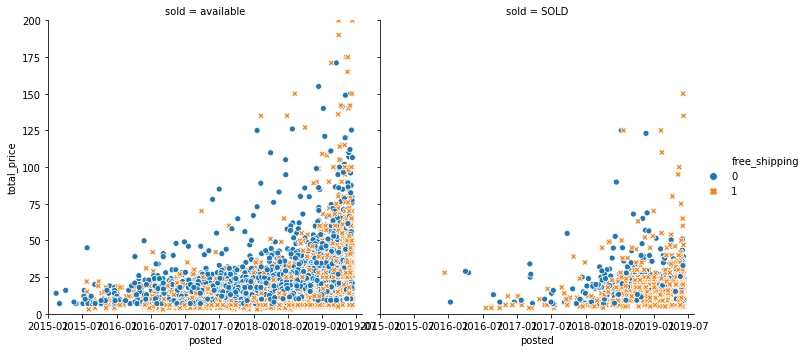

In [23]:
#Total price against date color coded by sold or for sale
# There seem to be a higher proporiton of free shipping purchases to non free shipping purchases in the sold graph!
%matplotlib inline
import seaborn as sns
book_plot = sns.relplot(x="posted", y="total_price", col="sold", hue = "free_shipping", style="free_shipping", data=books)
book_plot.set(xlim=(datetime.date(2015, 1, 1), datetime.date(2019, 8, 1)), ylim=(0,200))
book_plot


In [24]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# books subsets
books_sold = books[books.sold_true == 1]
books_available = books[books.sold_true == 0]

# function to calculate what I want
def cum_books_sold (days):
    cum_books_sold = books_sold[(books_sold.days_since_posted <= days)].shape[0]
    return cum_books_sold
                           

def books_still_left (days):
    books_still_left = books_available.shape[0] - books_available[(books_available.days_since_posted <= days)].shape[0]
    return books_still_left

# creating a dataframe that has data I want to graph
l = [i for i in range(365)]
books_over_time = {'dsp': l}
bot = pd.DataFrame(data=books_over_time)
bot['books_sold_since'] = bot.dsp.apply(cum_books_sold)
bot['books_still_left'] = bot.dsp.apply(books_still_left)
bot


,dsp,books_sold_since,books_still_left
0,0,0,21087
1,1,23,20895
2,2,34,20764
3,3,47,20547
4,4,56,20403
5,5,69,20230
6,6,77,20088
7,7,99,19945
8,8,111,19801
9,9,119,19677


### This is my justification for moving days since posted to 3 months rather than 2 weeks.

<IPython.core.display.Javascript object>


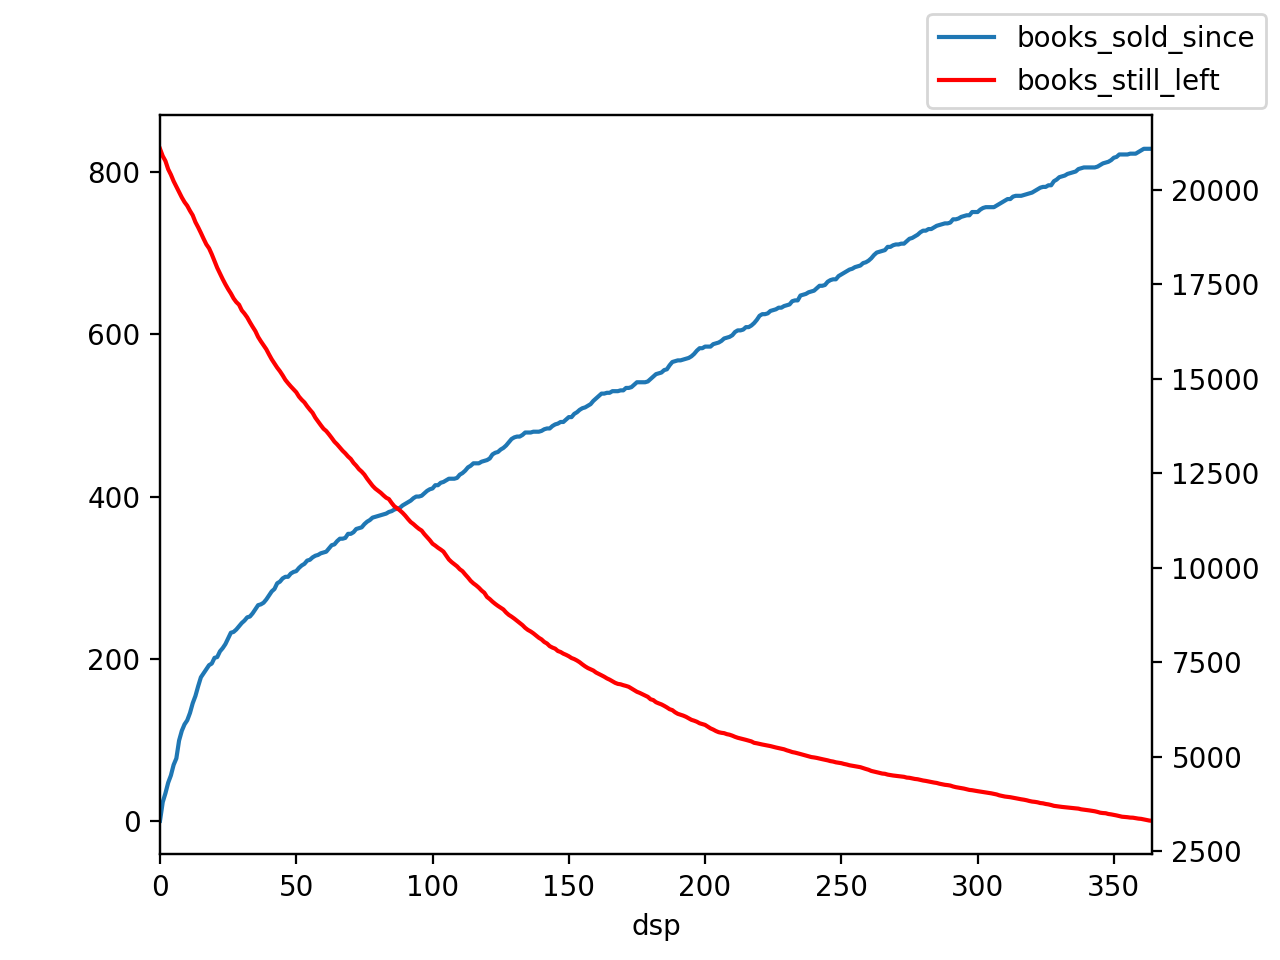

In [25]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt

ax = bot.plot(x="dsp", y="books_sold_since", legend=False)
ax2 = ax.twinx()
bot.plot(x="dsp", y="books_still_left", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

### Maybe focus on the one month mark (things that have sold within a month and things unsold after a month)

In [41]:
books_subset = books_filtered = books[((books.days_since_posted > 90) & (books.sold_true == 0)) | ((books.days_since_posted <= 90) & (books.sold_true == 1))]
books_subset.shape[0]

11773

## Now time for some exploratory statistics!

## Modelling Time!

In [57]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#removing the days_since_posted feature because of subsetting
feature_names_books = ['condition_ordinal','total_price', 'free_shipping', 
                       'brand_included', 'description_length'
                      ]
X_books = books_subset [feature_names_books]
y_books = books_subset ['sold_true']

X_train1, X_test_FINAL, y_train1, y_test_FINAL = train_test_split(X_books, y_books, random_state=0)
X_train2, X_test, y_train2, y_test = train_test_split(X_train1, y_train1, random_state=0)

# SMOTE TO UPSAMPLE FOR THE WIN!!!!
X_train, y_train = SMOTE().fit_resample(X_train2, y_train2)
y_resampled.shape[0]




# Need to look at features and think about whether things needs to be scaled. Shipping location excluded 
# because one hot encoding that does not seem to be worthwhile. I am going to create a condition_ordinal feature scale.
# Also going to create a days_since_posted scale.

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test1_scaled = scaler.transform(X_test1)


/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Dummy Classifier

In [28]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'stratified').fit(X_train_scaled, y_train)
print(dummy_majority.score(X_test_scaled, y_test))

dummy_majority_predicted = dummy_majority.predict(X_test_scaled)
confusion = confusion_matrix(y_test, dummy_majority_predicted)

print('Random class-proportional prediction (dummy classifier)\n', confusion)

0.5107214934409687
Random class-proportional prediction (dummy classifier)
 [[2041 1925]
 [1965 1997]]


In [47]:
print('Accuracy of dummy classifier on ORIGINAL subtest set: {:.4f}'
     .format(dummy_majority.score(X_test1, y_test1)))

dummy_majority_predicted = dummy_majority.predict(X_test1_scaled)
dummy_majority_confusion = confusion_matrix(y_test1, dummy_majority_predicted)

print('Dummy Majority \n', dummy_majority_confusion)

Accuracy of dummy classifier on ORIGINAL subtest set: 0.4966
Dummy Majority 
 [[1362 1481]
 [  43   58]]


### KNN

I don't think it's reliable to use KNN and SMOTE simultaneously because SMOT may use the KNN method to upsample

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_scaled, y_train)
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(X_train_scaled, y_train)))
print('Accuracy of K-NN classifier on test set: {:.4f}'
     .format(knn.score(X_test_scaled, y_test)))

knn_predicted = knn.predict(X_test_scaled)
knn_confusion = confusion_matrix(y_test, knn_predicted)

print('KNN\n', knn_confusion)

Accuracy of K-NN classifier on training set: 0.9357
Accuracy of K-NN classifier on test set: 0.9065
KNN
 [[3594  372]
 [ 369 3593]]


### Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver = 'lbfgs').fit(X_train_scaled, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.4f}'
     .format(logreg.score(X_train_scaled, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.4f}'
     .format(logreg.score(X_test_scaled, y_test)))

logreg_predicted = logreg.predict(X_test_scaled)
logreg_confusion = confusion_matrix(y_test, logreg_predicted)

print('Logistic Regression\n', logreg_confusion)

Accuracy of Logistic regression classifier on training set: 0.5654
Accuracy of Logistic regression classifier on test set: 0.5711
Logistic Regression
 [[1964 2002]
 [1398 2564]]


### Ridge Regression with Feature Normalization

In [35]:
from sklearn.linear_model import Ridge

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))



ridge regression linear model intercept: 0.311721747825589
ridge regression linear model coeff:
[0.02179547 0.6513468  0.16073864 0.02921111 0.08021726]
R-squared score (training): 0.033
R-squared score (test): 0.041
Number of non-zero features: 5


### SVC

In [36]:
from sklearn.svm import LinearSVC

svc = LinearSVC().fit(X_train_scaled, y_train)
print('Accuracy of Linear SVC classifier on training set: {:.4f}'
     .format(svc.score(X_train_scaled, y_train)))
print('Accuracy of Linear SVC classifier on test set: {:.4f}'
     .format(svc.score(X_test_scaled, y_test)))

svc_predicted = svc.predict(X_test_scaled)
svc_confusion = confusion_matrix(y_test, svc_predicted)

print('SVC \n', svc_confusion)

Accuracy of Linear SVC classifier on training set: 0.5649
Accuracy of Linear SVC classifier on test set: 0.5706
SVC 
 [[1960 2006]
 [1398 2564]]


### Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_train_scaled, y_train)
print('Accuracy of GaussianNB classifier on training set: {:.4f}'
     .format(nb.score(X_train_scaled, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.4f}'
     .format(nb.score(X_test_scaled, y_test)))

nb_predicted = nb.predict(X_test_scaled)
nb_confusion = confusion_matrix(y_test, nb_predicted)

print('Naive Bayes \n', nb_confusion)

Accuracy of GaussianNB classifier on training set: 0.6091
Accuracy of GaussianNB classifier on test set: 0.6126
Naive Bayes 
 [[3003  963]
 [2108 1854]]


### Random Forests

In [52]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_split = 10, n_estimators = 1000, random_state=0).fit(X_train_scaled, y_train)
print('Accuracy of RF classifier on training set: {:.4f}'
     .format(rf.score(X_train_scaled, y_train)))
print('Accuracy of RF classifier on test set: {:.4f}'
     .format(rf.score(X_test_scaled, y_test)))

rf_predicted = rf.predict(X_test_scaled)
rf_confusion = confusion_matrix(y_test, rf_predicted)

print('Random Forest \n', rf_confusion)

Accuracy of RF classifier on training set: 0.9800
Accuracy of RF classifier on test set: 0.9663
Random Forest 
 [[2057   63]
 [  81 2069]]


In [53]:
print('Accuracy of RF classifier on ORIGINAL subtest set: {:.4f}'
     .format(rf.score(X_test1_scaled, y_test1)))

rf_predicted = rf.predict(X_test1_scaled)
rf_confusion = confusion_matrix(y_test1, rf_predicted)

print('Random Forest \n', rf_confusion)

Accuracy of RF classifier on ORIGINAL subtest set: 0.9409
Random Forest 
 [[2757   86]
 [  88   13]]


Okay, this seems more realistic now. We accuately detected 15 of the items that actually sold, but misclassified quite a few as well.

In [43]:
# Cross validation scores
from sklearn.model_selection import cross_val_score

rf_cv_score = cross_val_score(rf, X_resampled, y_resampled, cv=10, scoring='roc_auc')

print("=== All AUC Scores ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rf_cv_score.mean())

=== All AUC Scores ===
[0.92420226 0.99231339 0.9944249  0.99324231 0.99734874 0.98448045
 0.98617653 0.99258983 0.99289677 0.95697637]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9814651543780906


Wow these AUC scores from cross validation look really good! I need to create an AUC plot to include! 
=== All AUC Scores ===
[0.92420226 0.99231339 0.9944249  0.99324231 0.99734874 0.98448045
 0.98617653 0.99258983 0.99289677 0.95697637]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9814651543780906

In [54]:
print("Column names: ", str(feature_names_books))

Column names:  ['condition_ordinal', 'total_price', 'free_shipping', 'brand_included', 'description_length']


Feature ranking:
1. feature 3 (0.290473)
2. feature 2 (0.257819)
3. feature 0 (0.173882)
4. feature 1 (0.139828)
5. feature 4 (0.137998)


<IPython.core.display.Javascript object>


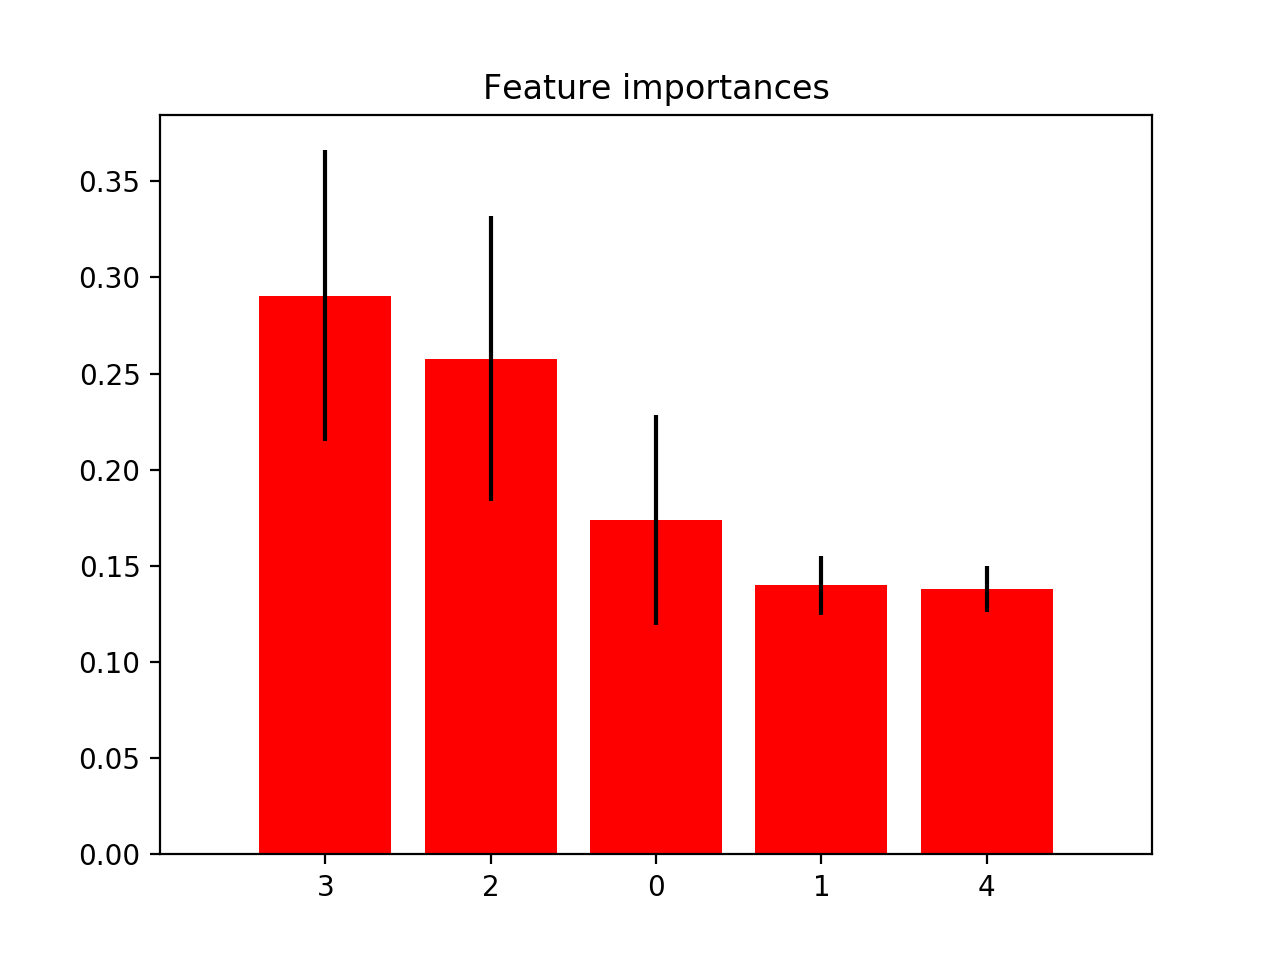

In [55]:

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Pritn features: 
X_train
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_scaled.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()



Strange. Free shipping and including a Brand are some of the most important features. Sklearns features importances has been criticized as being biased because it inflates the importance of continuous or high cardinality variables which isn't the case with either of these features.

Strange. Free shipping and including a Brand are some of the most important features.

### AUC Curves here?

In [56]:
from sklearn.metrics import roc_curve, auc

y_score_rf = rf.decision_function(X_test_scaled)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf )

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [244]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y_binary_imbalanced, random_state=0)

y_score_lr = lr.fit(X_train, y_train).decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

NameError: name 'X' is not defined

### Gradient-Boosted Decision Trees

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 0)
gbdt.fit(X_train_scaled, y_train)
print('(learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.4f}'
     .format(gbdt.score(X_train_scaled, y_train)))
print('Accuracy of GBDT classifier on test set: {:.4f}'
     .format(gbdt.score(X_test_scaled, y_test)))

gbdt_predicted = gbdt.predict(X_test_scaled)
gbdt_confusion = confusion_matrix(y_test, gbdt_predicted)

print('Gradient-Boosted Decision Trees \n', gbdt_confusion)

(learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.8257
Accuracy of GBDT classifier on test set: 0.8304
Gradient-Boosted Decision Trees 
 [[2382  484]
 [ 481 2344]]


## Evaluating these metrics with alternative models

In [25]:
from sklearn.metrics import classification_report

print('Dummy predictor (most frequent) \n', classification_report(y_test, dummy_majority_predicted, target_names=['available', 'sold']))
print('KNN \n', classification_report(y_test, knn_predicted, target_names=['available', 'sold']))
print('Logistic regression\n', classification_report(y_test, logreg_predicted, target_names = ['available', 'sold']))
print('SVC\n', classification_report(y_test, svc_predicted, target_names = ['available', 'sold']))
print('Naive Bayes\n', classification_report(y_test, nb_predicted, target_names = ['available', 'sold']))
print('Random Forest\n', classification_report(y_test, rf_predicted, target_names = ['available', 'sold']))
print('Gradient-Boosted Decision Trees\n', classification_report(y_test, gbdt_predicted, target_names = ['available', 'sold']))

Dummy predictor (most frequent) 
               precision    recall  f1-score   support

   available       0.50      0.50      0.50      2866
        sold       0.50      0.50      0.50      2825

   micro avg       0.50      0.50      0.50      5691
   macro avg       0.50      0.50      0.50      5691
weighted avg       0.50      0.50      0.50      5691

KNN 
               precision    recall  f1-score   support

   available       0.94      0.93      0.93      2866
        sold       0.93      0.94      0.93      2825

   micro avg       0.93      0.93      0.93      5691
   macro avg       0.93      0.93      0.93      5691
weighted avg       0.93      0.93      0.93      5691

Logistic regression
               precision    recall  f1-score   support

   available       0.76      0.79      0.77      2866
        sold       0.78      0.75      0.76      2825

   micro avg       0.77      0.77      0.77      5691
   macro avg       0.77      0.77      0.77      5691
weighted avg 